In [7]:
import geopandas as gpd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns


import mapclassify as mc
from scipy.stats import norm
import contextily
from pysal.lib import weights  # Spatial weights
from pysal.explore import esda
import shapely
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import libpysal as ps 
%matplotlib inline 

import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

In [8]:
scot_simd=gpd.read_file('data/SG_SIMD_2020/SG_SIMD_2020.shp')



In [9]:
df1=pd.read_csv('data/Final_results.csv')
df2=pd.read_csv('data/POI_diversity.csv')

In [10]:
df3=pd.read_csv('data/UKBuildings_age.csv')

In [11]:
df4=pd.read_excel('data/GDP2020.xlsx',sheet_name='Table 2',header=1) #从第二行开始读作为表头

In [12]:
df5=pd.read_excel('data/Population_TabA.xlsx',sheet_name='TabA',header=2)

In [13]:
df4=df4[df4['LAD name']=='Glasgow City']

In [14]:
df4.columns

Index([  'DZ code',   'DZ name',  'LAD code',  'LAD name', 'ITL1 code',
       'ITL1 name',        1998,        1999,        2000,        2001,
              2002,        2003,        2004,        2005,        2006,
              2007,        2008,        2009,        2010,        2011,
              2012,        2013,        2014,        2015,        2016,
              2017,        2018,        2019,        2020],
      dtype='object')

In [15]:
df4=df4[['DZ code',2020]]

In [16]:
df4.columns=['DataZone','GVA2020']

In [17]:
df5=df5[df5['Council area']=='Glasgow City']
df5=df5[['DataZone2011Code','Total population']]


In [18]:
df5.columns=['DataZone','Total_population']

In [19]:
df5

DataZone  Total_population
3253  S01009758             583.0
3254  S01009759             901.0
3255  S01009760             843.0
3256  S01009761             787.0
3257  S01009762            1327.0
...         ...               ...
3994  S01010499             838.0
3995  S01010500             975.0
3996  S01010501            1121.0
3997  S01010502             788.0
3998  S01010503             641.0

[746 rows x 2 columns]

In [20]:
gla_simd=scot_simd.loc[scot_simd['LAName']=='Glasgow City']

gla_geo=gla_simd[['DataZone','Quintilev2','geometry']]

df=gla_geo.merge(df1,how='left',on='DataZone')

df=df.merge(df2,how='left',on='DataZone')

df=df.merge(df4,how='left',on='DataZone')

df=df.merge(df5,how='left',on='DataZone')

In [21]:
df.columns

Index(['DataZone', 'Quintilev2', 'geometry', 'OBJECTID', 'Zone_area',
       'junction_count', 'junction_density', 'tourist_count',
       'tourist_density', 'industry_count', 'industry_density', 'office_count',
       'office_density', 'resid_count', 'resid_density', 'NTL_MEAN',
       'property_area', 'Number_of_Buildings', 'Building_Density',
       'Number_of_Busstops', 'busstops_Density',
       'Number_of_consumptionrelated', 'consumptionrelated_Density',
       'Buildingarea_divide_Datazone', 'VARIANCE_height', 'FAR', 'Unnamed: 0',
       'Richness', 'Shannon entropy', 'Simpson index', 'Join_Count',
       'Shape_Area', 'poi_ratio', 'GVA2020', 'Total_population'],
      dtype='object')

In [22]:
df['pop_density']=df['Total_population']/df['Zone_area']
df['Normalized_GVA']=df['GVA2020']/df['Zone_area']
df['Normalized_BHV']=df['VARIANCE_height']/df['Zone_area']

In [23]:
df['Quintilev2']=df['Quintilev2'].astype('str')


In [24]:
df_geo=df[['DataZone','geometry','NTL_MEAN','Quintilev2',
         'Buildingarea_divide_Datazone','FAR',
         'consumptionrelated_Density','tourist_density','industry_density','office_density','resid_density',
         'Shannon entropy','Normalized_BHV',
         'junction_density','busstops_Density',
         'pop_density','Normalized_GVA']]

In [25]:
df=df[['NTL_MEAN',
         'Buildingarea_divide_Datazone','FAR',
         'consumptionrelated_Density','tourist_density','industry_density','office_density','resid_density',
         'Shannon entropy','Normalized_BHV',
         'junction_density','busstops_Density',
         'pop_density','Normalized_GVA']]

In [26]:
df.columns

Index(['NTL_MEAN', 'Buildingarea_divide_Datazone', 'FAR',
       'consumptionrelated_Density', 'tourist_density', 'industry_density',
       'office_density', 'resid_density', 'Shannon entropy', 'Normalized_BHV',
       'junction_density', 'busstops_Density', 'pop_density',
       'Normalized_GVA'],
      dtype='object')

In [27]:
df.columns=['NTL_MEAN',
            'BD','FAR',
            'CPOI','TPOI','MPOI','OPOI','HPOI',
           'SE','BHV',
           'JD','BSD',
           'PD','GVA']

In [28]:
df_geo.columns=['DataZone','geometry','NTL_MEAN','Quintilev2',
                'BD','FAR',
                'CPOI','TPOI','MPOI','OPOI','HPOI',
               'SE','BHV',
               'JD','BSD',
               'PD','GVA']

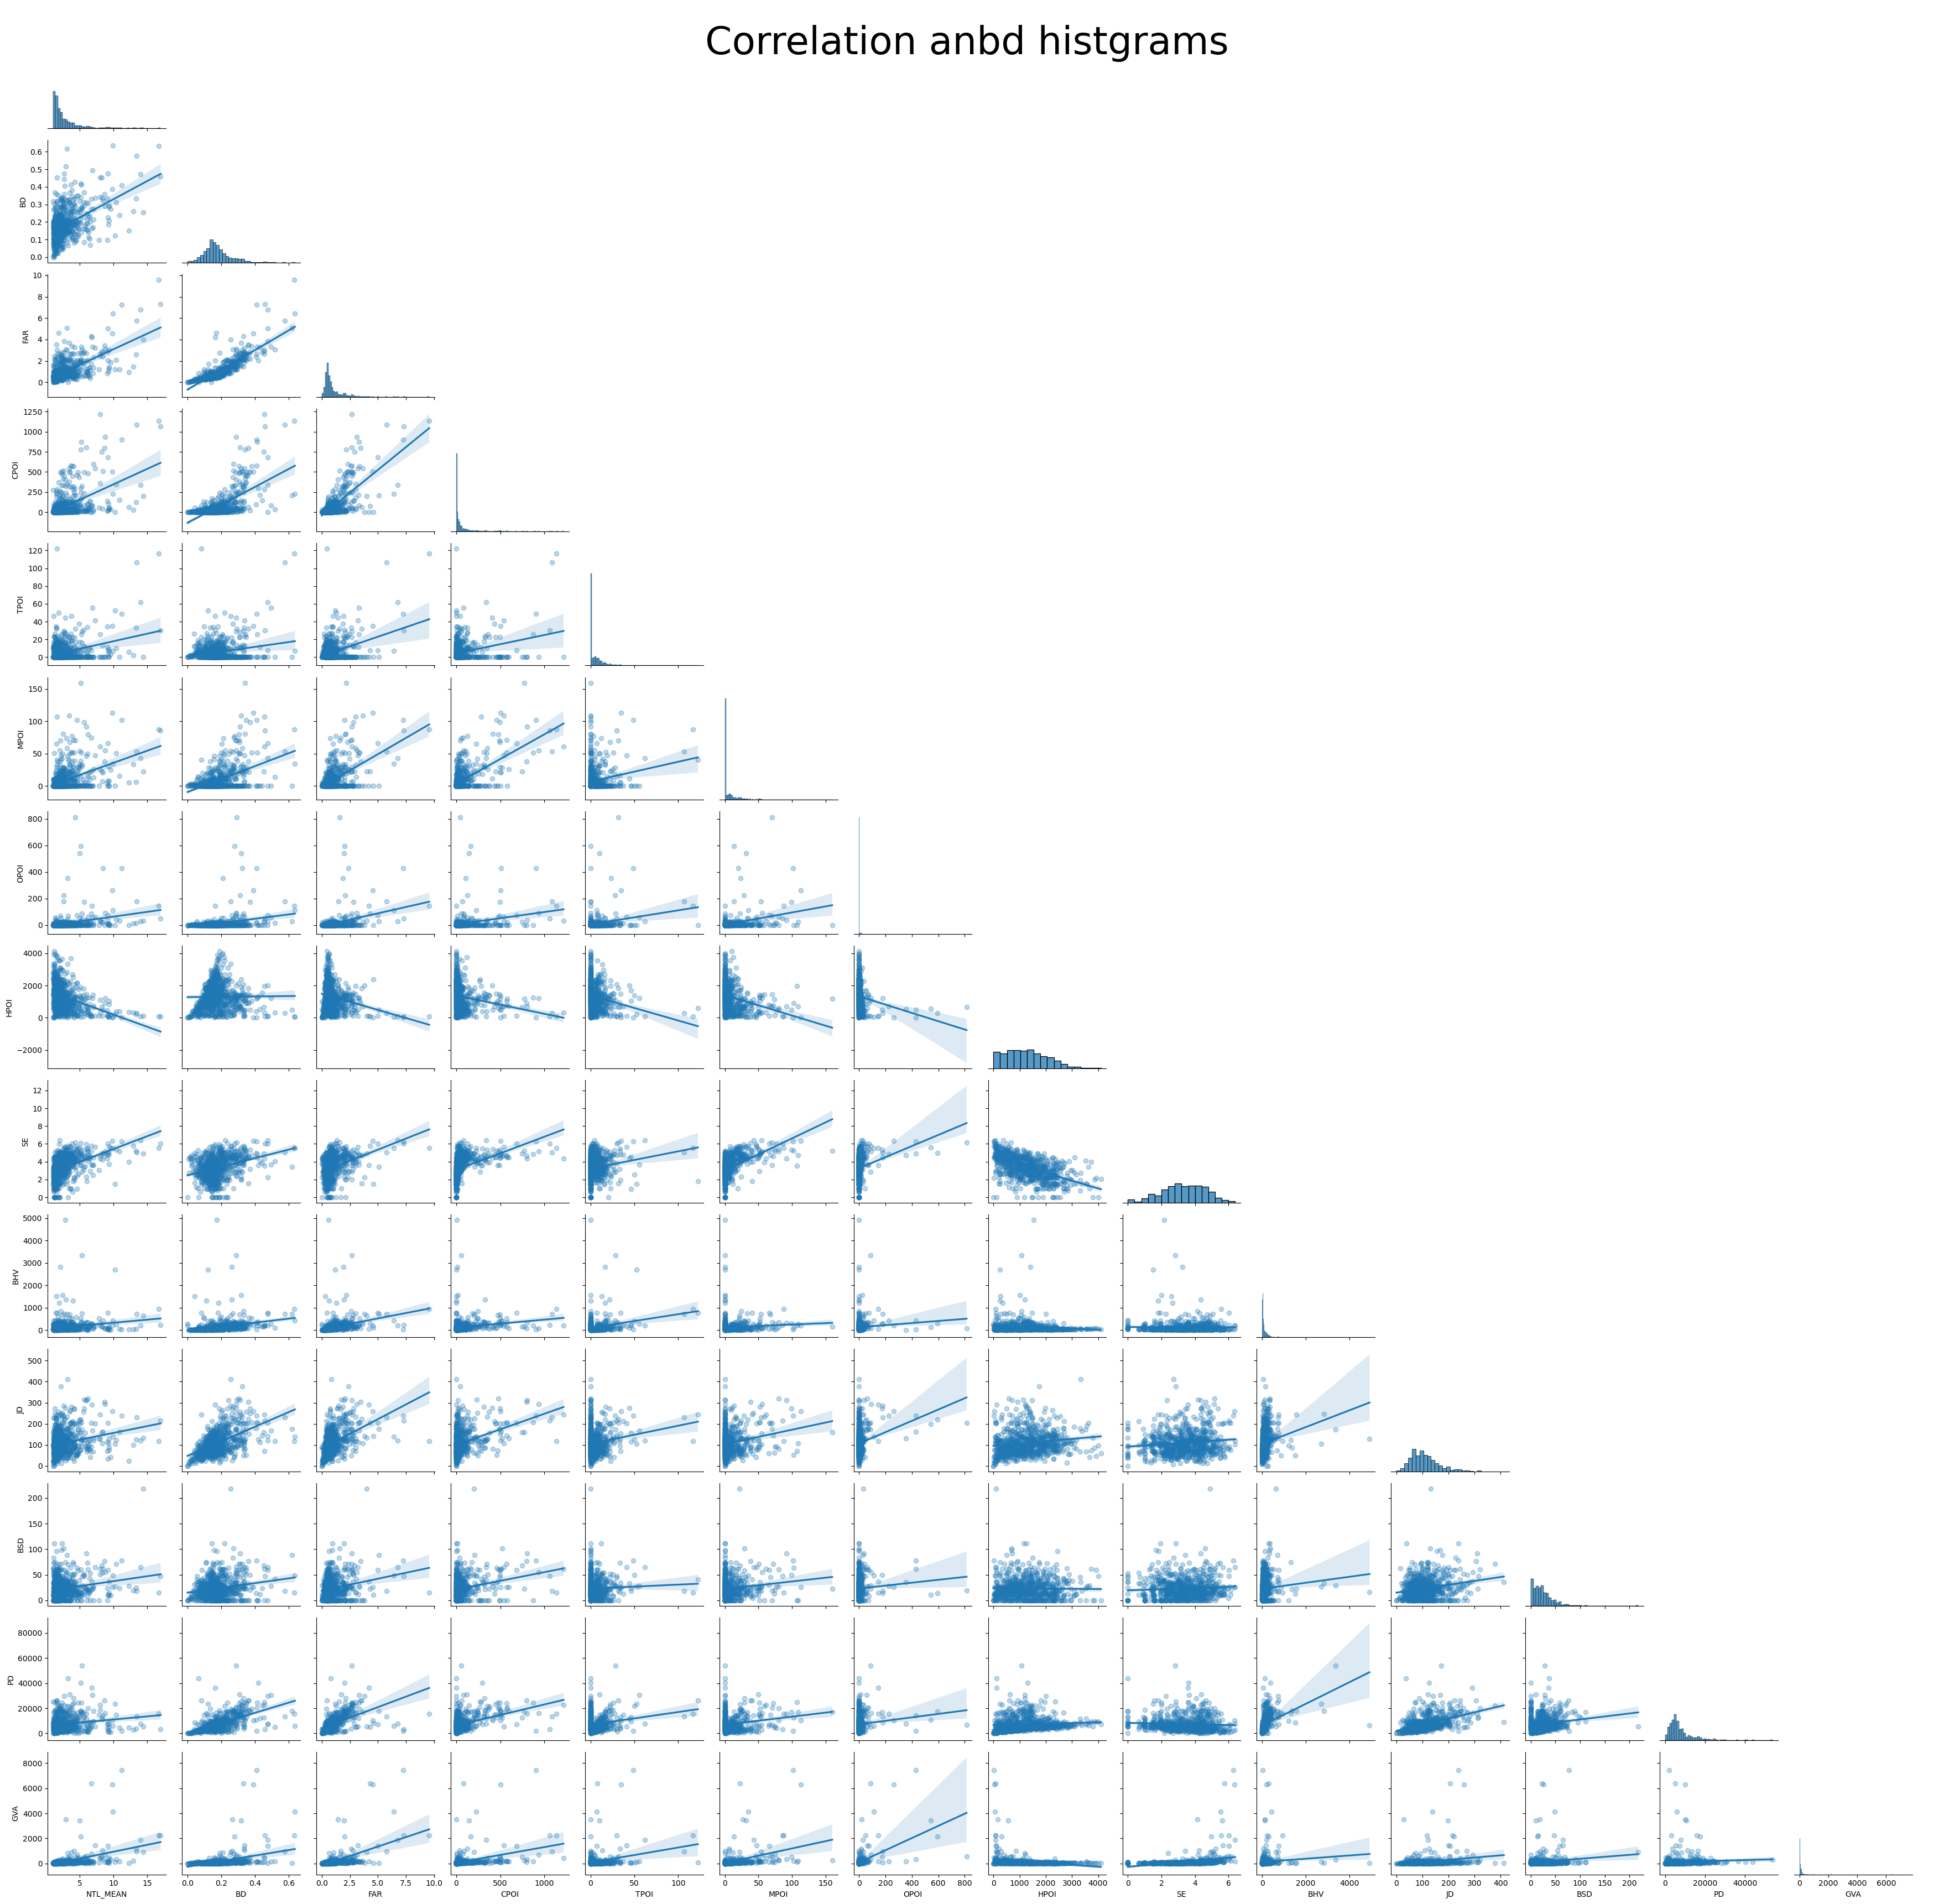

In [29]:
variables = ['NTL_MEAN',
            'BD','FAR',
            'CPOI','TPOI','MPOI','OPOI','HPOI',
           'SE','BHV',
           'JD','BSD',
           'PD','GVA']
mpl.rcParams["axes.labelsize"] = 20
g = sns.PairGrid(df_geo,vars=variables,corner=True)
plt.subplots_adjust(top=0.99)
g.map_diag(sns.histplot)
g.map_offdiag(sns.regplot,scatter_kws={'alpha':0.3})
g.add_legend()
g.fig.suptitle('Correlation anbd histgrams',fontsize=50)
plt.savefig('Scatter.jpg')
plt.show()


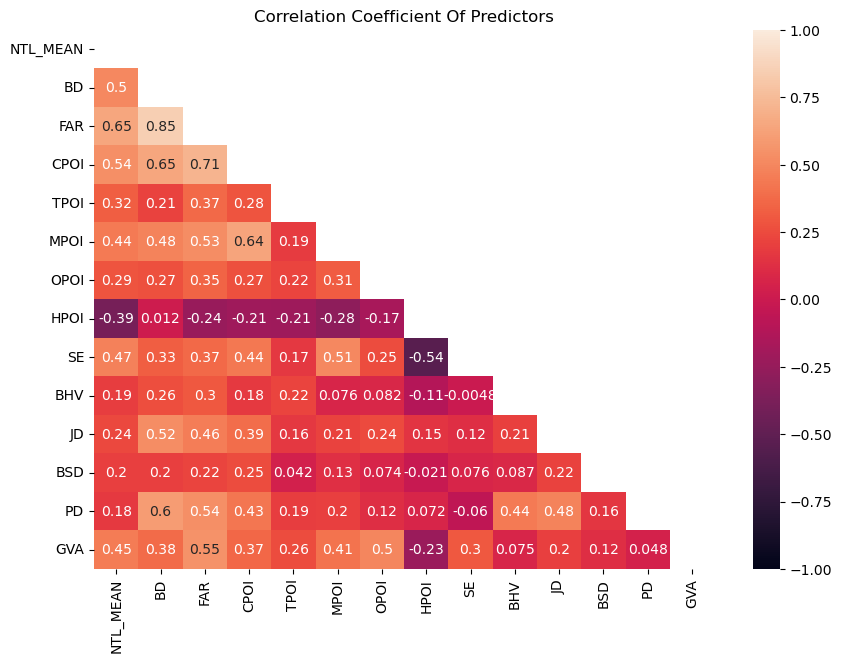

In [30]:
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.savefig('Pearson.jpg')
plt.show()


In [31]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('NTL_MEAN ~ FAR + CPOI + TPOI + MPOI + OPOI + HPOI + SE + BHV + JD + BSD +  PD + GVA', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns


vif

VIF   variable
0   26.878523  Intercept
1    3.626848        FAR
2    2.771857       CPOI
3    1.223895       TPOI
4    2.000077       MPOI
5    1.413728       OPOI
6    1.663001       HPOI
7    2.027689         SE
8    1.316439        BHV
9    1.612950         JD
10   1.095086        BSD
11   2.197429         PD
12   1.975275        GVA

In [32]:
# construct the regression equation
reg_exp = 'NTL_MEAN ~ FAR + CPOI + TPOI + MPOI + OPOI + HPOI + SE + BHV + JD + BSD +  PD + GVA'

# build the OLS regression model:
olsr_model = smf.ols(formula=reg_exp, data=df)

# train the model:
olsr_model_results = olsr_model.fit()

# print out the training summary:
print(olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:               NTL_MEAN   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     69.17
Date:                Sun, 02 Apr 2023   Prob (F-statistic):          8.05e-112
Time:                        22:18:33   Log-Likelihood:                -1339.6
No. Observations:                 745   AIC:                             2705.
Df Residuals:                     732   BIC:                             2765.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4584      0.280      5.209      0.0

In [33]:
olsr_model_results.resid

0      0.528674
1     -1.248897
2     -1.267646
3      0.040475
4     -0.956630
         ...   
741    0.156826
742   -0.205124
743   -0.180524
744    0.066603
745    1.051018
Length: 745, dtype: float64

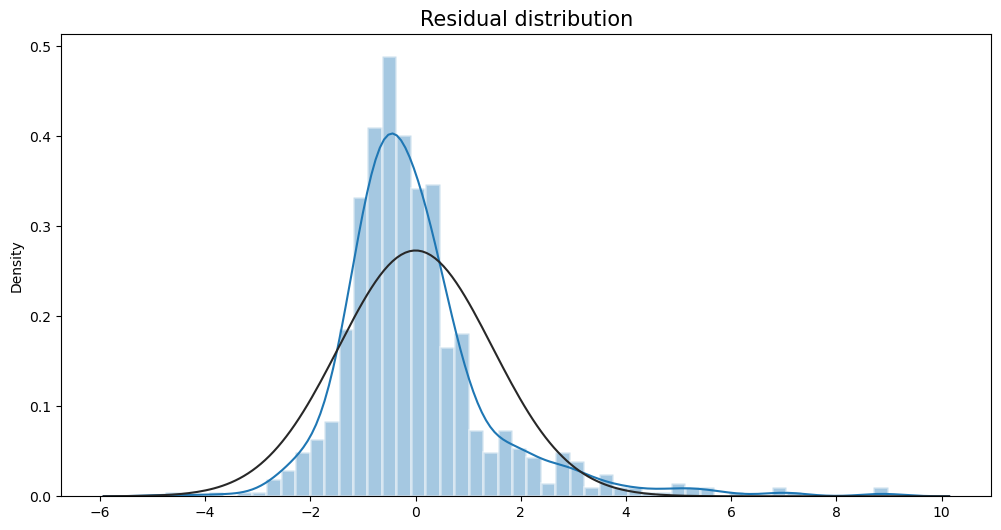

In [34]:
from scipy import stats
fig,ax=plt.subplots(figsize=(12,6))
sns.distplot(olsr_model_results.resid, fit=stats.norm,hist_kws=dict(edgecolor="white", linewidth=2))
ax.set_title('Residual distribution', fontsize=15)
plt.savefig('Residual distribution.jpg')
plt.show()

In [35]:
df_geo['resid']=olsr_model_results.resid

In [36]:
df_geo.isnull().sum()

DataZone      0
geometry      0
NTL_MEAN      0
Quintilev2    0
BD            0
FAR           0
CPOI          0
TPOI          0
MPOI          0
OPOI          0
HPOI          0
SE            1
BHV           0
JD            0
BSD           0
PD            0
GVA           0
resid         1
dtype: int64

In [37]:
df_geo=df_geo.fillna(0)

In [38]:
df_geo.to_csv('data/residual.csv')

In [39]:
df_geo.to_crs(epsg=3857, inplace=True)

In [40]:
gla_geo.to_crs(epsg=3857, inplace=True)

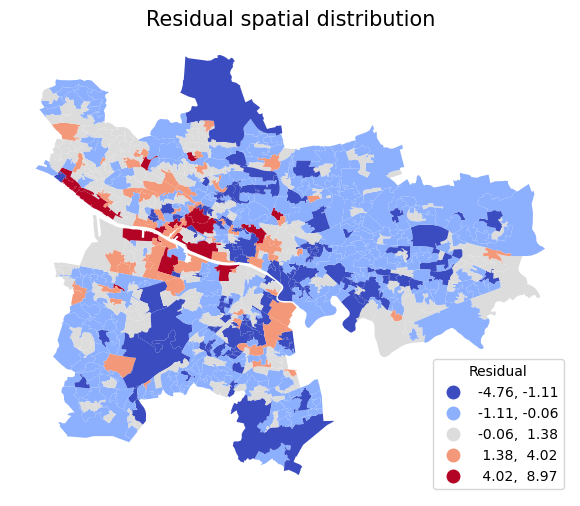

In [41]:
fig,ax=plt.subplots(figsize=(12,6))
df_geo.plot(ax=ax,column='resid', 
                 cmap = 'coolwarm', 
                 figsize=(28,10),
                 scheme='NaturalBreaks',
                 k=5, 
                 legend = True, 
                 legend_kwds = {'title':'Residual','loc':'lower right'})
ax.set_title('Residual spatial distribution', fontsize=15)


ax.set_axis_off()

In [42]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(df_geo, k=8)
# Row-standardization
w.transform = "R"

#compute the spatial lag of rediduals
df_geo["resid"] = weights.spatial_lag.lag_spatial(w, df_geo["resid"])

moran_resid = esda.moran.Moran(df_geo["resid"], w)

moran_resid.p_sim

0.001

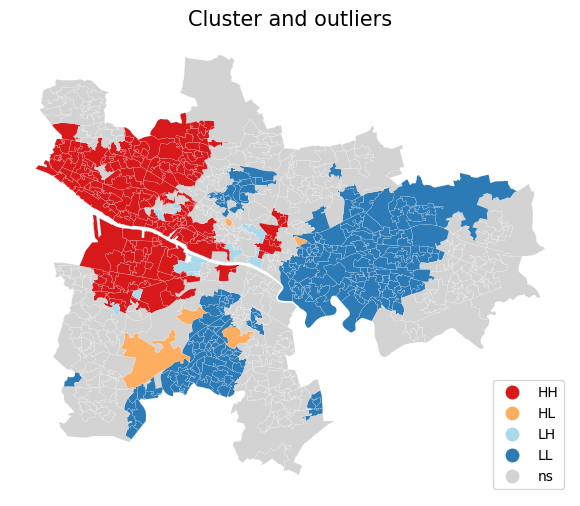

In [43]:
lisa = esda.moran.Moran_Local(df_geo["resid"], w,permutations=9999)
from splot import esda as esdaplot

# Set up figure and axes
fig,ax=plt.subplots(figsize=(12,6))
# Plot Quandrant colors In this case, we use a 5% significance
esdaplot.lisa_cluster(lisa, df_geo, p=0.05, ax=ax,legend = True, 
                 legend_kwds = {'loc':'lower right'})

ax.set_title('Cluster and outliers', fontsize=15)
ax.set_axis_off()
# Display the figure

plt.show()


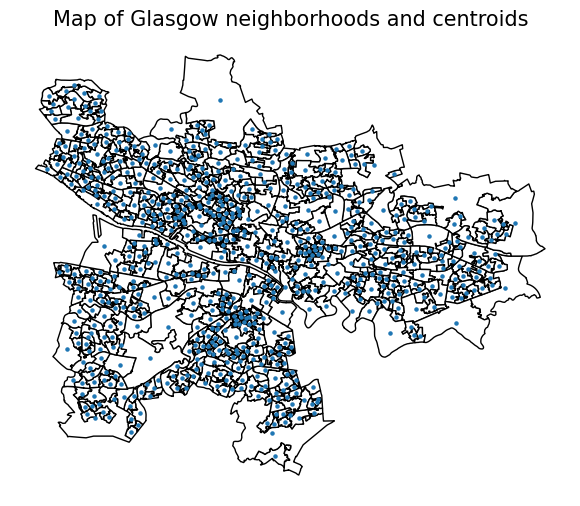

In [44]:
#GWR regression
fig, ax = plt.subplots(figsize=(12, 6))
gla_geo.plot(color = 'white', edgecolor = 'black', ax = ax)
gla_geo.centroid.plot(ax=ax,markersize=5)
ax.set_title('Map of Glasgow neighborhoods and centroids', fontsize=15)
ax.axis("off")
plt.show()

In [45]:
y = df_geo['NTL_MEAN'].values.reshape((-1,1)) # reshape is needed to have column array
y.shape

(746, 1)

In [46]:
X = df_geo[['FAR','CPOI','TPOI', 'MPOI','OPOI','HPOI', 'SE', 'BHV','JD', 'BSD', 'PD','GVA']].values
X.shape

(746, 12)

In [47]:
df_geo['X'] = df_geo.geometry.centroid.x
df_geo['Y'] = df_geo.geometry.centroid.y

In [48]:
df_geo.isnull().values.any()

False

In [49]:
df_geo=df_geo.fillna(0)

In [50]:
u = df_geo['X']
v = df_geo['Y']
coords = list(zip(u,v))

In [51]:
X = (X - X.mean(axis=0)) / X.std(axis=0)

y = y.reshape((-1,1))

y = (y - y.mean(axis=0)) / y.std(axis=0)

In [52]:
%%time
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

CPU times: user 4.95 s, sys: 7.26 s, total: 12.2 s
Wall time: 2.96 s


In [53]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 260.0


In [54]:
df_geo.to_csv('data/residual.csv')

In [55]:
gwr_results = GWR(coords, y, X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 746
Number of covariates:                                                    13

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            349.356
Log-likelihood:                                                    -775.558
AIC:                                                               1577.116
AICc:                                                              1579.691
BIC:                                                              -4499.237
R2:                                                                   0.532
Adj. R2:                                                              0.524

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [56]:
#Calibrate MGWR model
mgwr_selector = Sel_BW(coords, y, X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(coords, y, X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[214. 154. 744. 268. 744. 744.  20. 744.  67. 744. 346. 744. 734.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 746
Number of covariates:                                                    13

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            349.356
Log-likelihood:                                                    -775.558
AIC:                                                               1577.116
AICc:                                                              1579.691
BIC:                                                              -4499.237
R2:                                                                   0.532
Adj. R2:                                                              0.524

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [59]:
#Random Forest Regression
#import dataset
y = df_geo['NTL_MEAN']
x = df_geo.drop(['NTL_MEAN','DataZone','geometry','Quintilev2','BD','X','Y','resid'], axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)

In [60]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [61]:
from sklearn.metrics import mean_squared_error # for calculating the cost function
# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  1.257


In [62]:
from sklearn.metrics import r2_score
y_true = y_test # True values
R_squared = r2_score(y_true, y_pred)
print(R_squared)

0.5216968340231104


### With X and Y coordinates

In [175]:
#XGBoost
#import dataset
y = df_geo['NTL_MEAN']
X = df_geo.drop(['NTL_MEAN','DataZone','geometry','Quintilev2','resid'], axis=1)



In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1018)

#Train model
model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3) 
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [177]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print("MSE: {:.2f}".format(mse))
print("RMSE: {:.2f}".format(rmse))
print("\nR square:",np.round(r2_score(y_test, y_pred),2))


MSE: 2.66
RMSE: 1.63

R square: 0.49


In [178]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X)

In [179]:
from sklearn.metrics import mean_squared_error as mse

#Get model predictions
y_pred = model.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("\nModel prediction: {}".format(y_pred[0]))
print("\nMean prediction + interaction values: {}".format(mean_pred+sum_shap))

MSE = mse(y, y_pred) 
RMSE = np.sqrt(MSE)
print("\nRMSE:", np.round(RMSE, 2))
print("\nR square:",np.round(r2_score(y, y_pred),2))



Model prediction: 1.3171443939208984

Mean prediction + interaction values: 1.3449084758758545

RMSE: 0.78

R square: 0.86


In [180]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
avg_score = -scores.mean()

print("Average score: {:.2f}".format(avg_score))

Average score: 2.44


Text(0.5, 0, 'Actual')

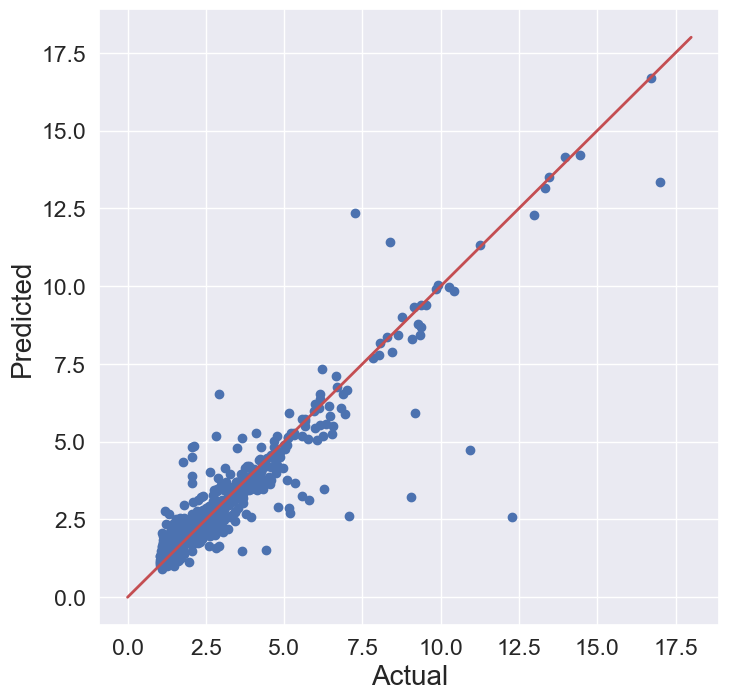

In [181]:
#Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
plt.plot([0, 18], [0, 18], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'BD'),
  Text(0, 1.5, 'FAR'),
  Text(0, 2.5, 'CPOI'),
  Text(0, 3.5, 'TPOI'),
  Text(0, 4.5, 'MPOI'),
  Text(0, 5.5, 'OPOI'),
  Text(0, 6.5, 'HPOI'),
  Text(0, 7.5, 'SE'),
  Text(0, 8.5, 'BHV'),
  Text(0, 9.5, 'JD'),
  Text(0, 10.5, 'BSD'),
  Text(0, 11.5, 'PD'),
  Text(0, 12.5, 'GVA'),
  Text(0, 13.5, 'X'),
  Text(0, 14.5, 'Y')])

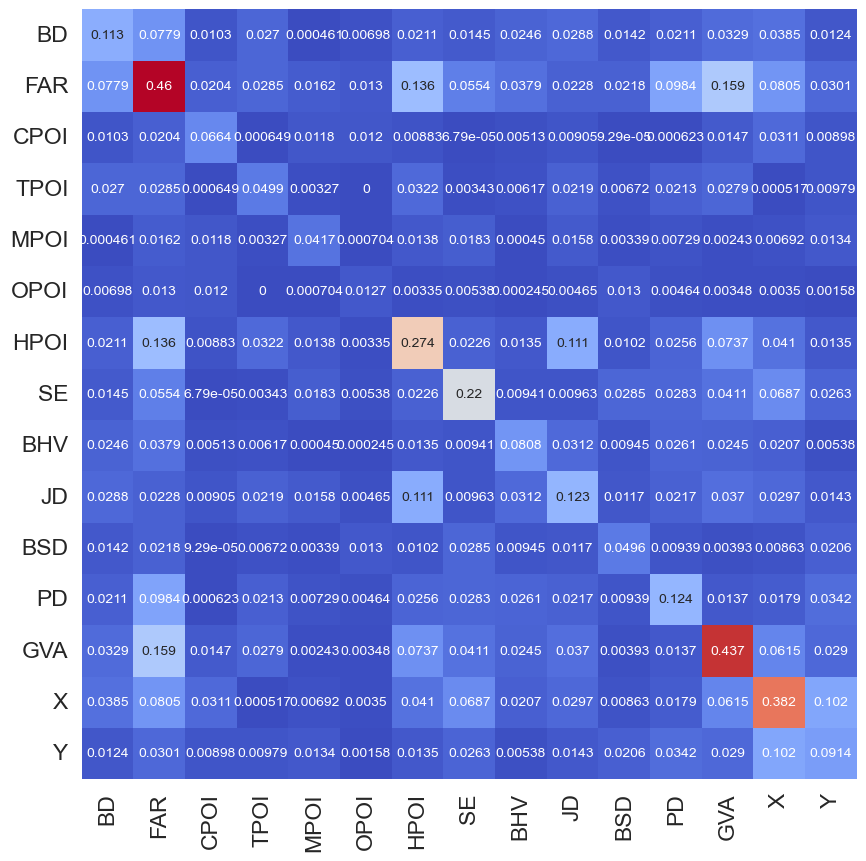

In [182]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False,annot_kws={"size": 10})
plt.yticks(rotation=0) 

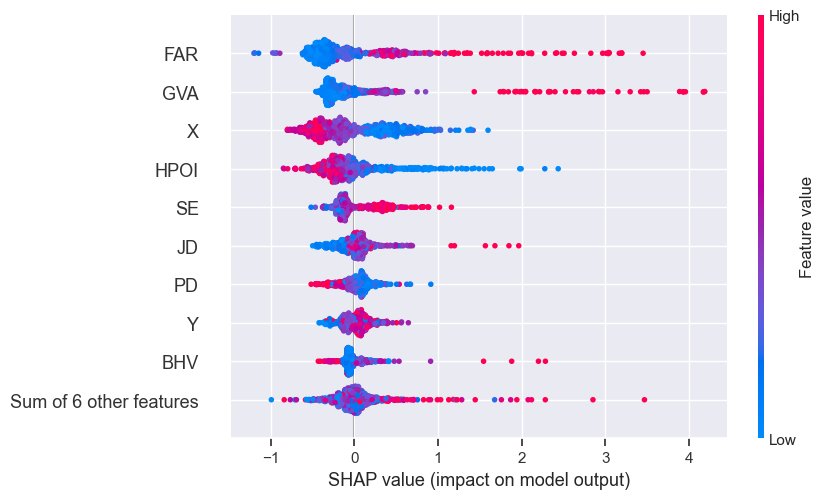

In [183]:
# Get SHAP values
shap_values = explainer(X)

#Display beeswarm plot
shap.plots.beeswarm(shap_values)

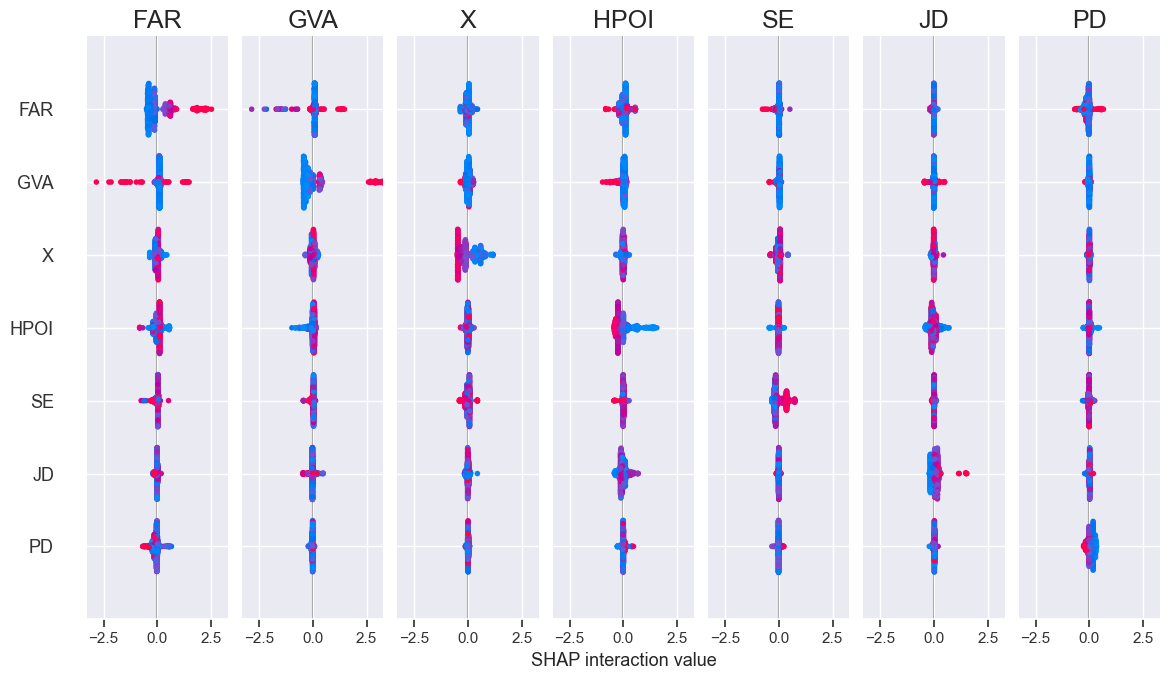

In [184]:
#Display summary plot
shap.summary_plot(shap_interaction, X)#颜色由y轴的特征值给出

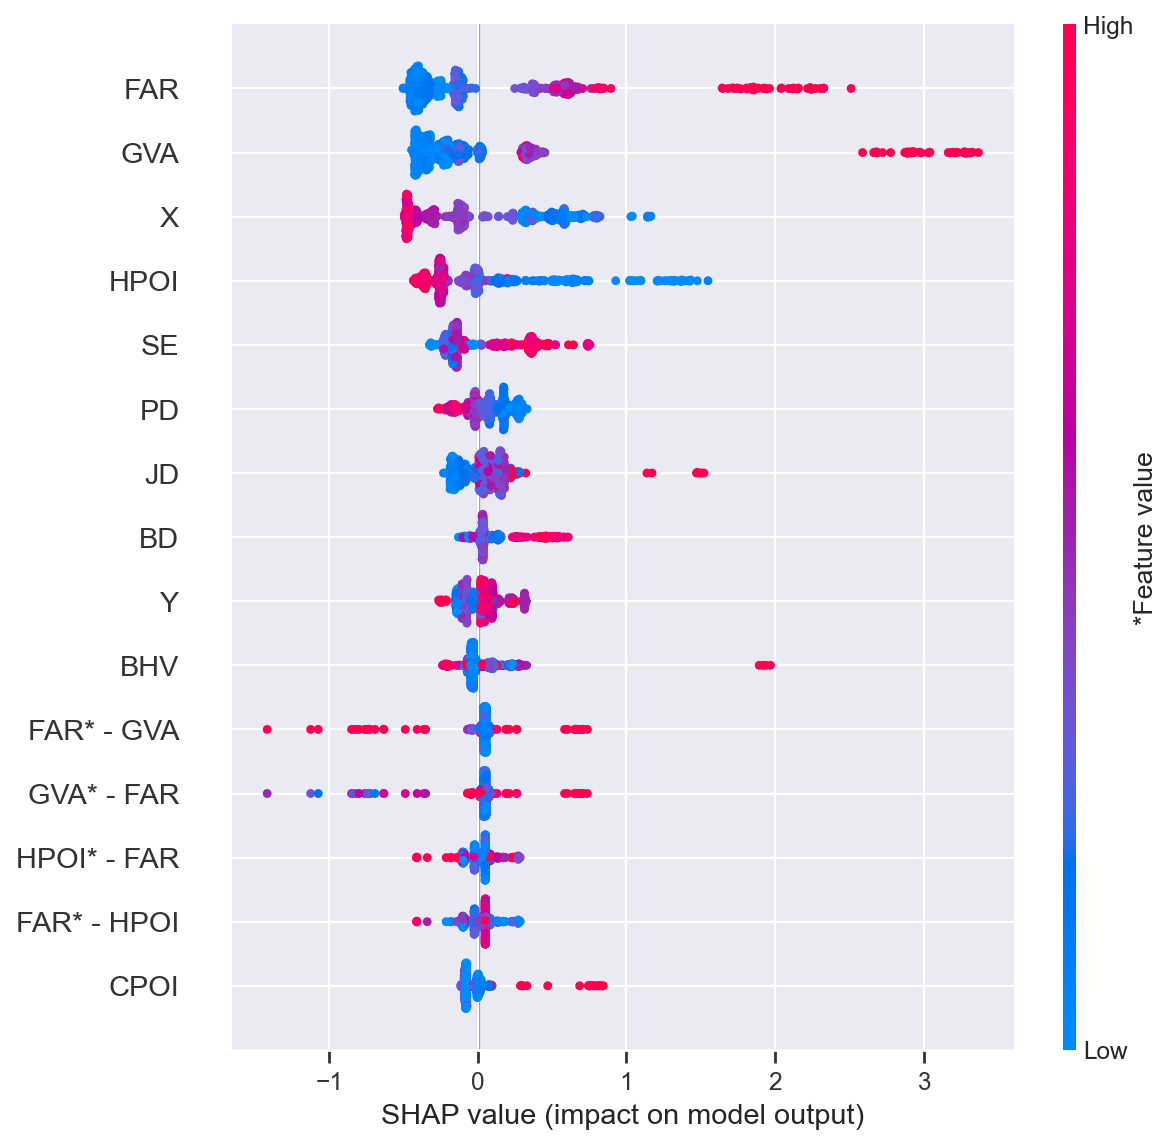

In [185]:
fig, ax = plt.subplots(figsize=(8, 6),dpi=160)

shap.summary_plot(shap_interaction, X, max_display=15,
                  plot_type="compact_dot")

In [186]:
#XGBoost with coords of X and Y
#import dataset
y = df_geo['NTL_MEAN']
X_coords = df_geo.drop(['NTL_MEAN','DataZone','geometry','Quintilev2','resid'], axis=1)

In [187]:
from sklearn.metrics import mean_squared_error, r2_score

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_coords, y, 
                                                    test_size = 0.2,
                                                    random_state = 1018)

In [82]:
%%time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 30, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.05),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 30, 1, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.3, 1.01, 0.05),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 1.01, 0.05)),
        'gamma': hp.quniform('gamma', 0.1, 5, 0.05),
    
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
    }

def score(params, n_folds=5):
    
    #Cross-validation
    d_train = xgb.DMatrix(X_coords,y)
    
    cv_results = xgb.cv(params, d_train, nfold = n_folds, num_boost_round=500,
                        early_stopping_rounds = 10, metrics = 'rmse', seed = 0)
    
    loss = min(cv_results['test-rmse-mean'])
    
    return loss


def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=2000,
                rstate=np.random.default_rng(333))#Add seed to fmin function
    return best

CPU times: user 60.2 ms, sys: 38 ms, total: 98.2 ms
Wall time: 158 ms


In [83]:
trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
best_params = space_eval(space, best_params)

best_params

100%|██████| 2000/2000 [15:22<00:00,  2.17trial/s, best loss: 1.304071372269639]


{'colsample_bytree': 0.4,
 'eval_metric': 'rmse',
 'gamma': 3.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 3,
 'objective': 'reg:squarederror',
 'subsample': 0.65}

In [189]:
data_test = xgb.DMatrix(X_test,y_test)

data = xgb.DMatrix(X_train,y_train)
final_model = xgb.train(best_params, data, num_boost_round=500, verbose_eval=False,
                            evals=[(data_test, "Test")],early_stopping_rounds=10)
#                           用于monitor训练过程中的模型表现

data_all = xgb.DMatrix(X_coords)
y_pred = final_model.predict(data_all)
print(np.sqrt(mean_squared_error(y, y_pred)))
print(r2_score(y, y_pred))

print(np.mean(y_pred))

0.9274120938109716
0.8111205087257931
2.650634


Text(0.5, 0, 'Actual')

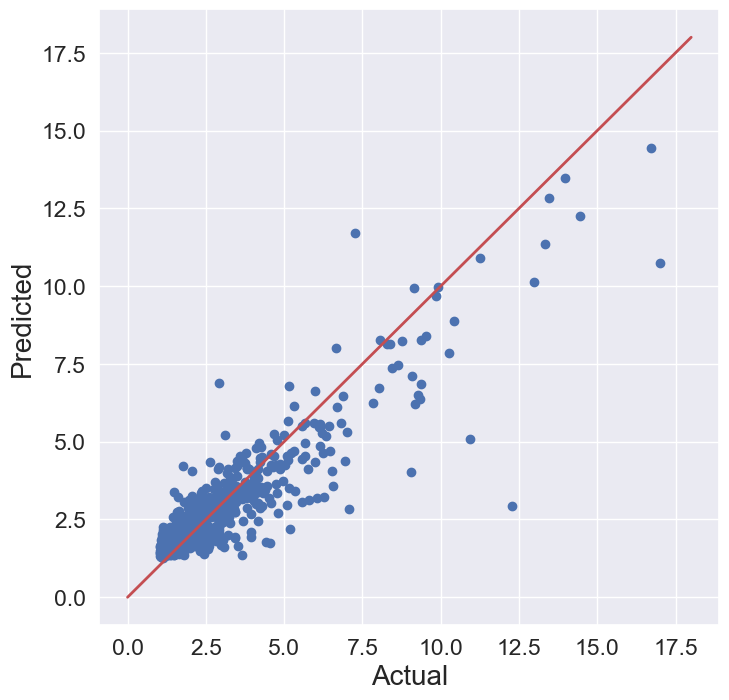

In [190]:
#Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
plt.plot([0, 18], [0, 18], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

In [191]:
# 如果用测试集去检测R square
data_test = xgb.DMatrix(X_test,y_test)

data = xgb.DMatrix(X_train,y_train)
final_model = xgb.train(best_params, data, num_boost_round=500, verbose_eval=False,
                            evals=[(data_test, "Test")],early_stopping_rounds=10)
#                           用于monitor训练过程中的模型表现

data_all = xgb.DMatrix(X_coords)
y_pred = final_model.predict(data_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

print(np.mean(y_pred))

1.581545625811366
0.522500162776127
2.6822627


### SHAP analysis of xgboost results

#### 修改model_1还是final_model

In [192]:
explainer = shap.TreeExplainer(final_model)
# explainer = shap.TreeExplainer(model_1)
shap_values = explainer(X_coords)

In [193]:

shap_interaction = explainer.shap_interaction_values(X_coords)

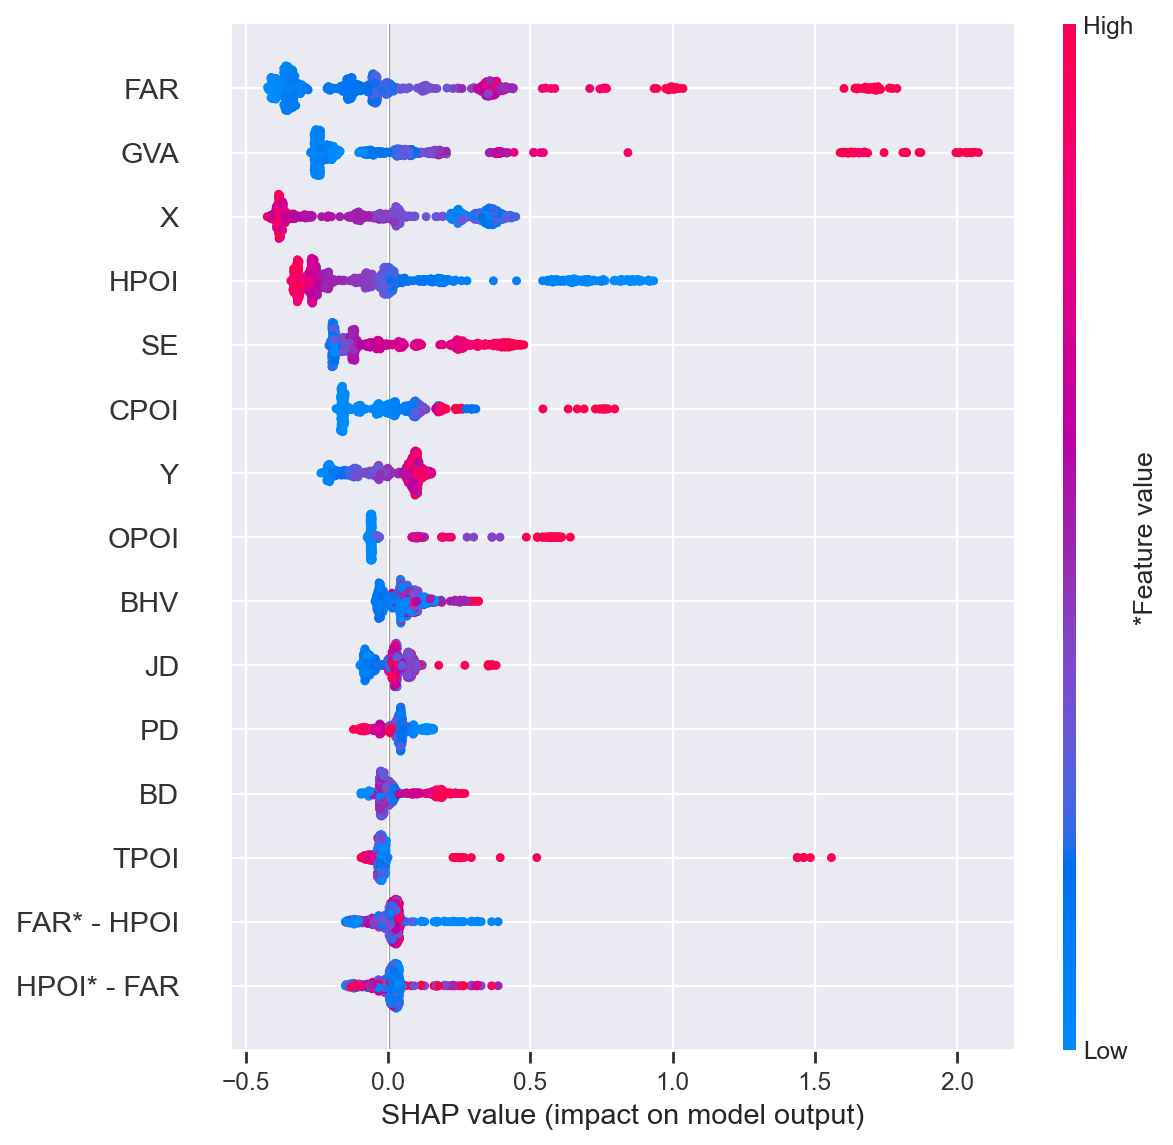

In [194]:
fig, ax = plt.subplots(figsize=(8, 6),dpi=160)

shap.summary_plot(shap_interaction, X_coords, max_display=15,
                  plot_type="compact_dot")

In [195]:
#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

print(mean_pred, sum_shap)


Model prediction: 2.755269765853882
Mean prediction + interaction values: 1.6185274124145508
2.6822627 -1.0637352


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'BD'),
  Text(0, 1.5, 'FAR'),
  Text(0, 2.5, 'CPOI'),
  Text(0, 3.5, 'TPOI'),
  Text(0, 4.5, 'MPOI'),
  Text(0, 5.5, 'OPOI'),
  Text(0, 6.5, 'HPOI'),
  Text(0, 7.5, 'SE'),
  Text(0, 8.5, 'BHV'),
  Text(0, 9.5, 'JD'),
  Text(0, 10.5, 'BSD'),
  Text(0, 11.5, 'PD'),
  Text(0, 12.5, 'GVA'),
  Text(0, 13.5, 'X'),
  Text(0, 14.5, 'Y')])

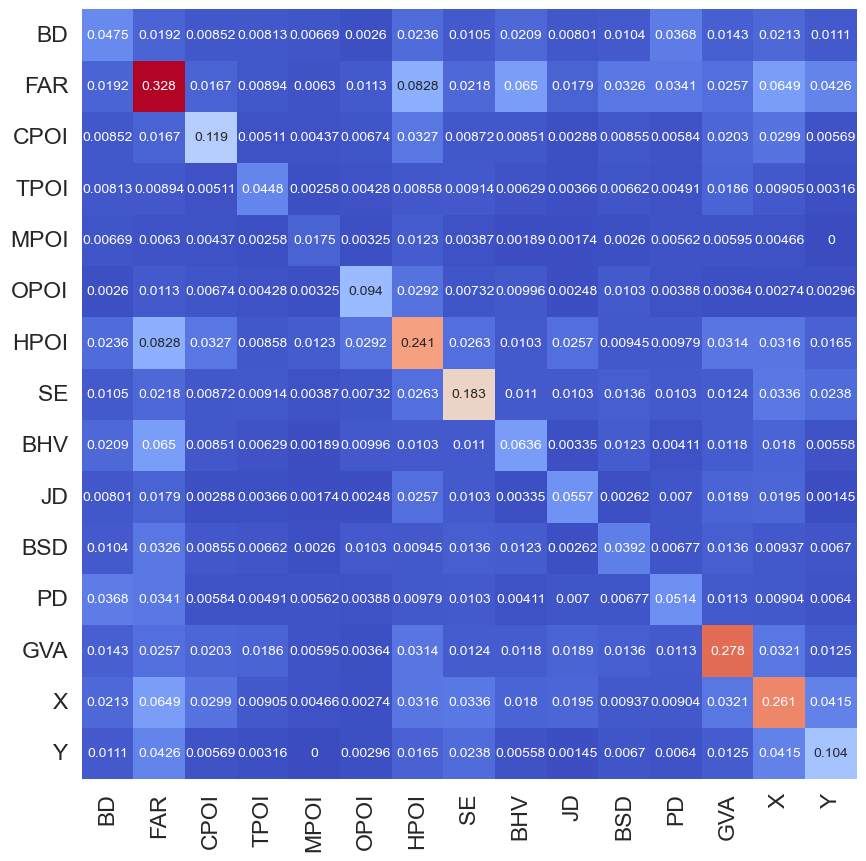

In [196]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X_coords.columns,columns=X_coords.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False,annot_kws={"size": 10})
plt.yticks(rotation=0) 

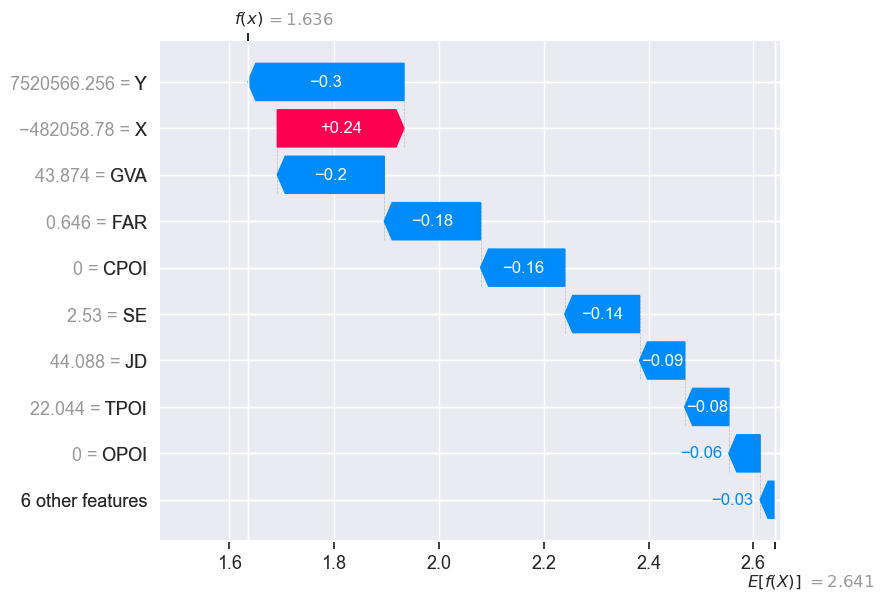

In [97]:
shap.plots.waterfall(shap_values[1])

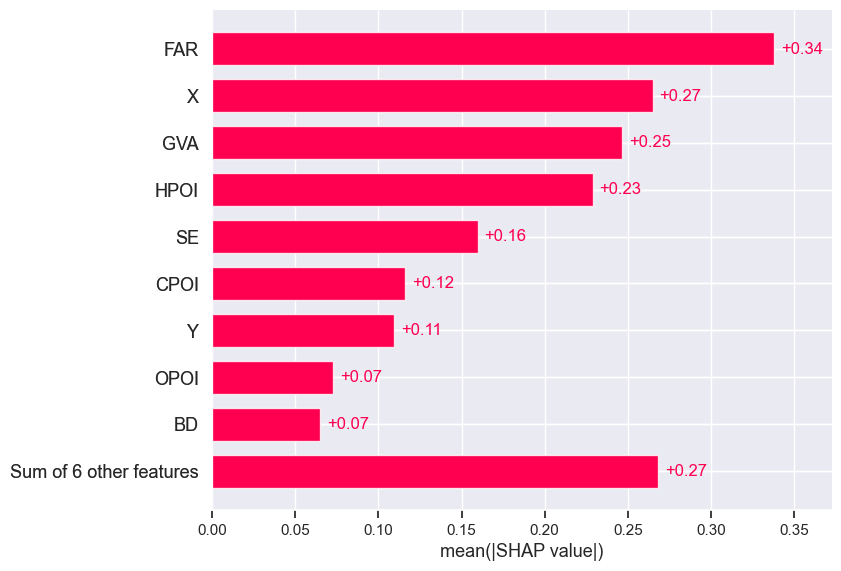

In [197]:
#Mean SHAP
shap.plots.bar(shap_values)

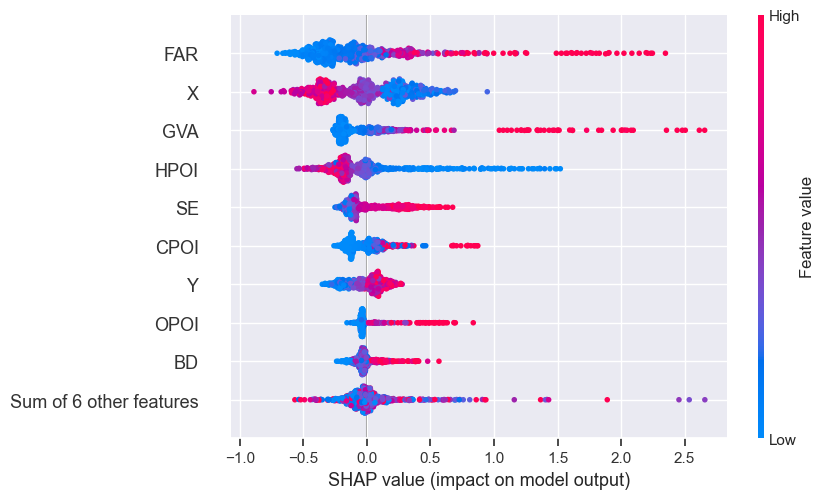

In [198]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

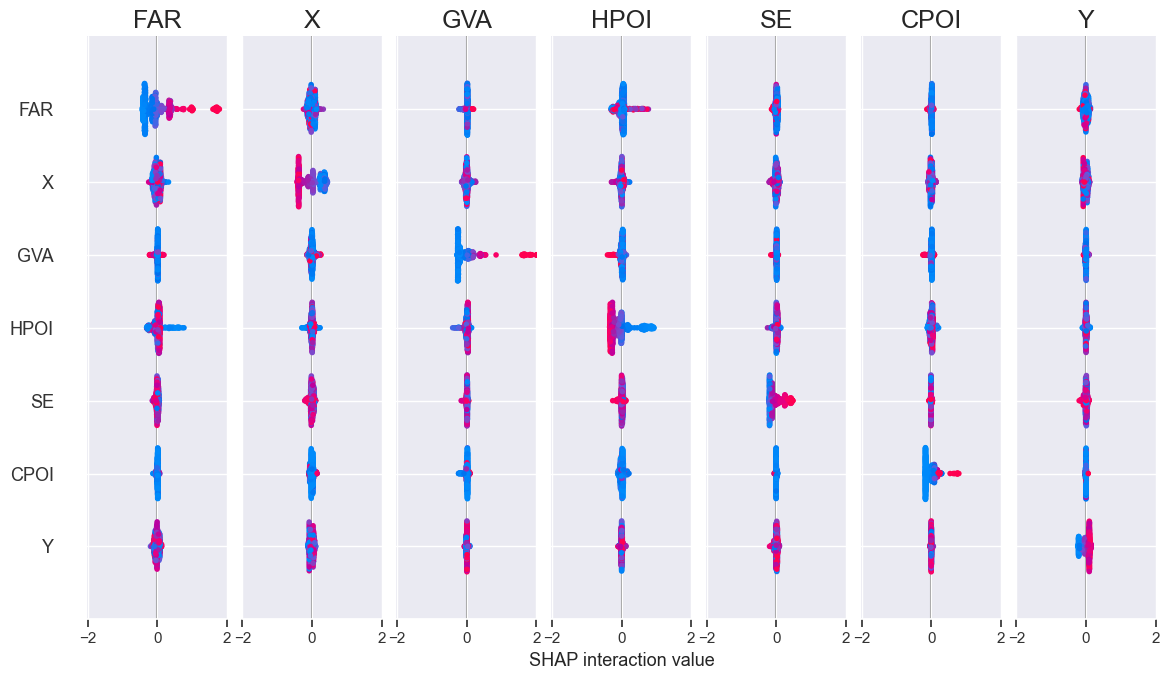

In [199]:
#Display interaction summary plot
shap.summary_plot(shap_interaction, X_coords)

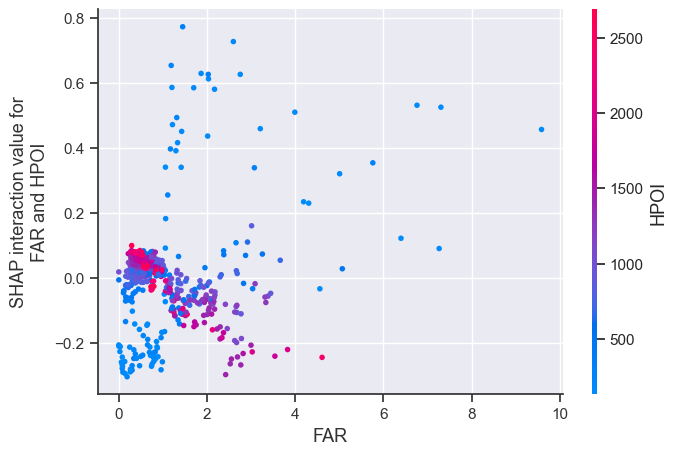

In [107]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("FAR", "HPOI"),
    shap_interaction, X_coords,
    display_features=X_coords)

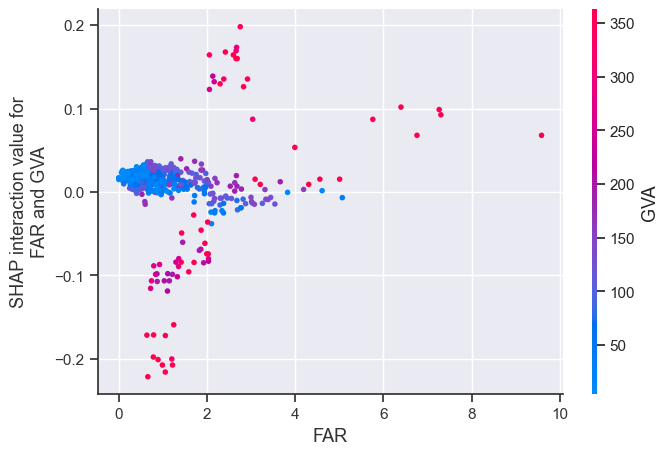

In [108]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("FAR", "GVA"),
    shap_interaction, X_coords,
    display_features=X_coords)

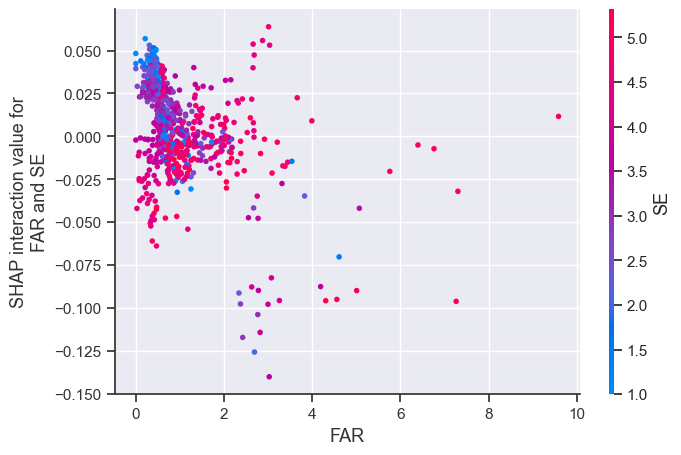

In [109]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("FAR", "SE"),
    shap_interaction, X_coords,
    display_features=X_coords)

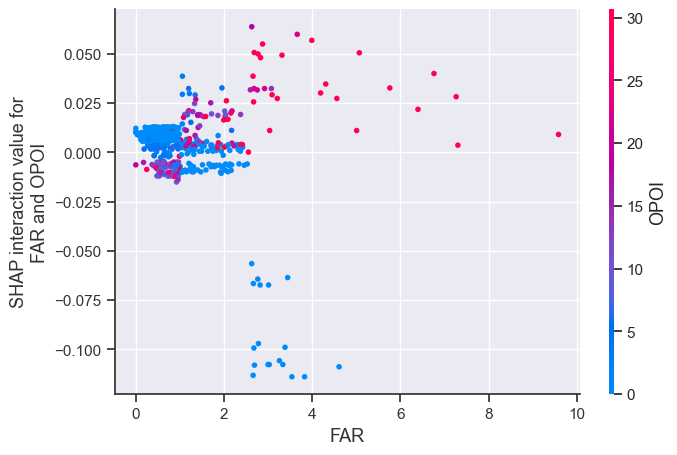

In [112]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("FAR", "OPOI"),
    shap_interaction, X_coords,
    display_features=X_coords)

### Compute the confidence intervals for the global shap values

### Spatial patterns of SHAP values

In [206]:
X_vars=['BD','FAR','CPOI','TPOI','MPOI','OPOI','HPOI','SE','BHV','JD','BSD','PD','GVA','X','Y']

(-490745.5677002986, -451476.4820628076, 7513525.925107571, 7545893.18295839)

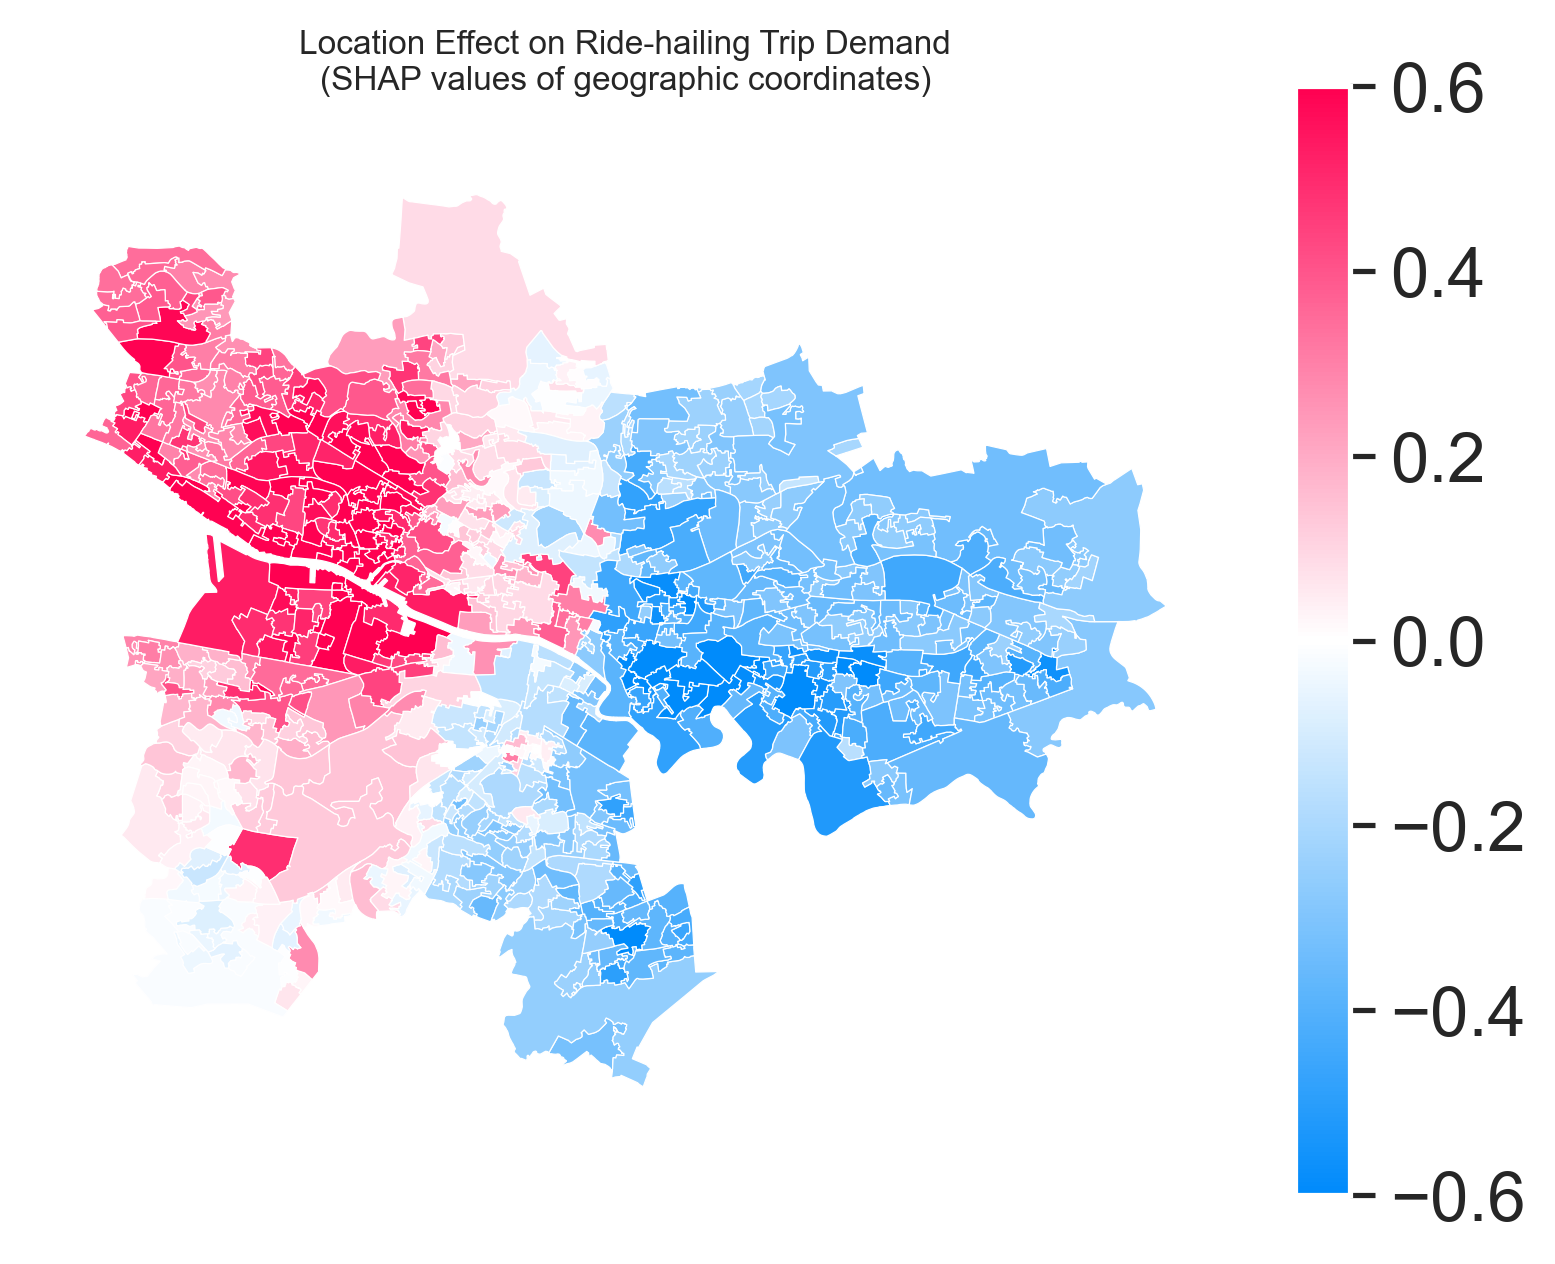

In [215]:
fig, ax = plt.subplots(dpi=300)

df_geo.plot(ax=ax,column = shap_values.values[:,-1] + shap_values.values[:,-2],
             legend=True,vmin=-0.6,vmax=0.6,figsize=(15,8),
                cmap=shap.plots.colors.red_white_blue,**{'edgecolor':'white','linewidth':0.3})


plt.title("Location Effect on Ride-hailing Trip Demand\n(SHAP values of geographic coordinates)\n",fontsize=8)

plt.axis('off')

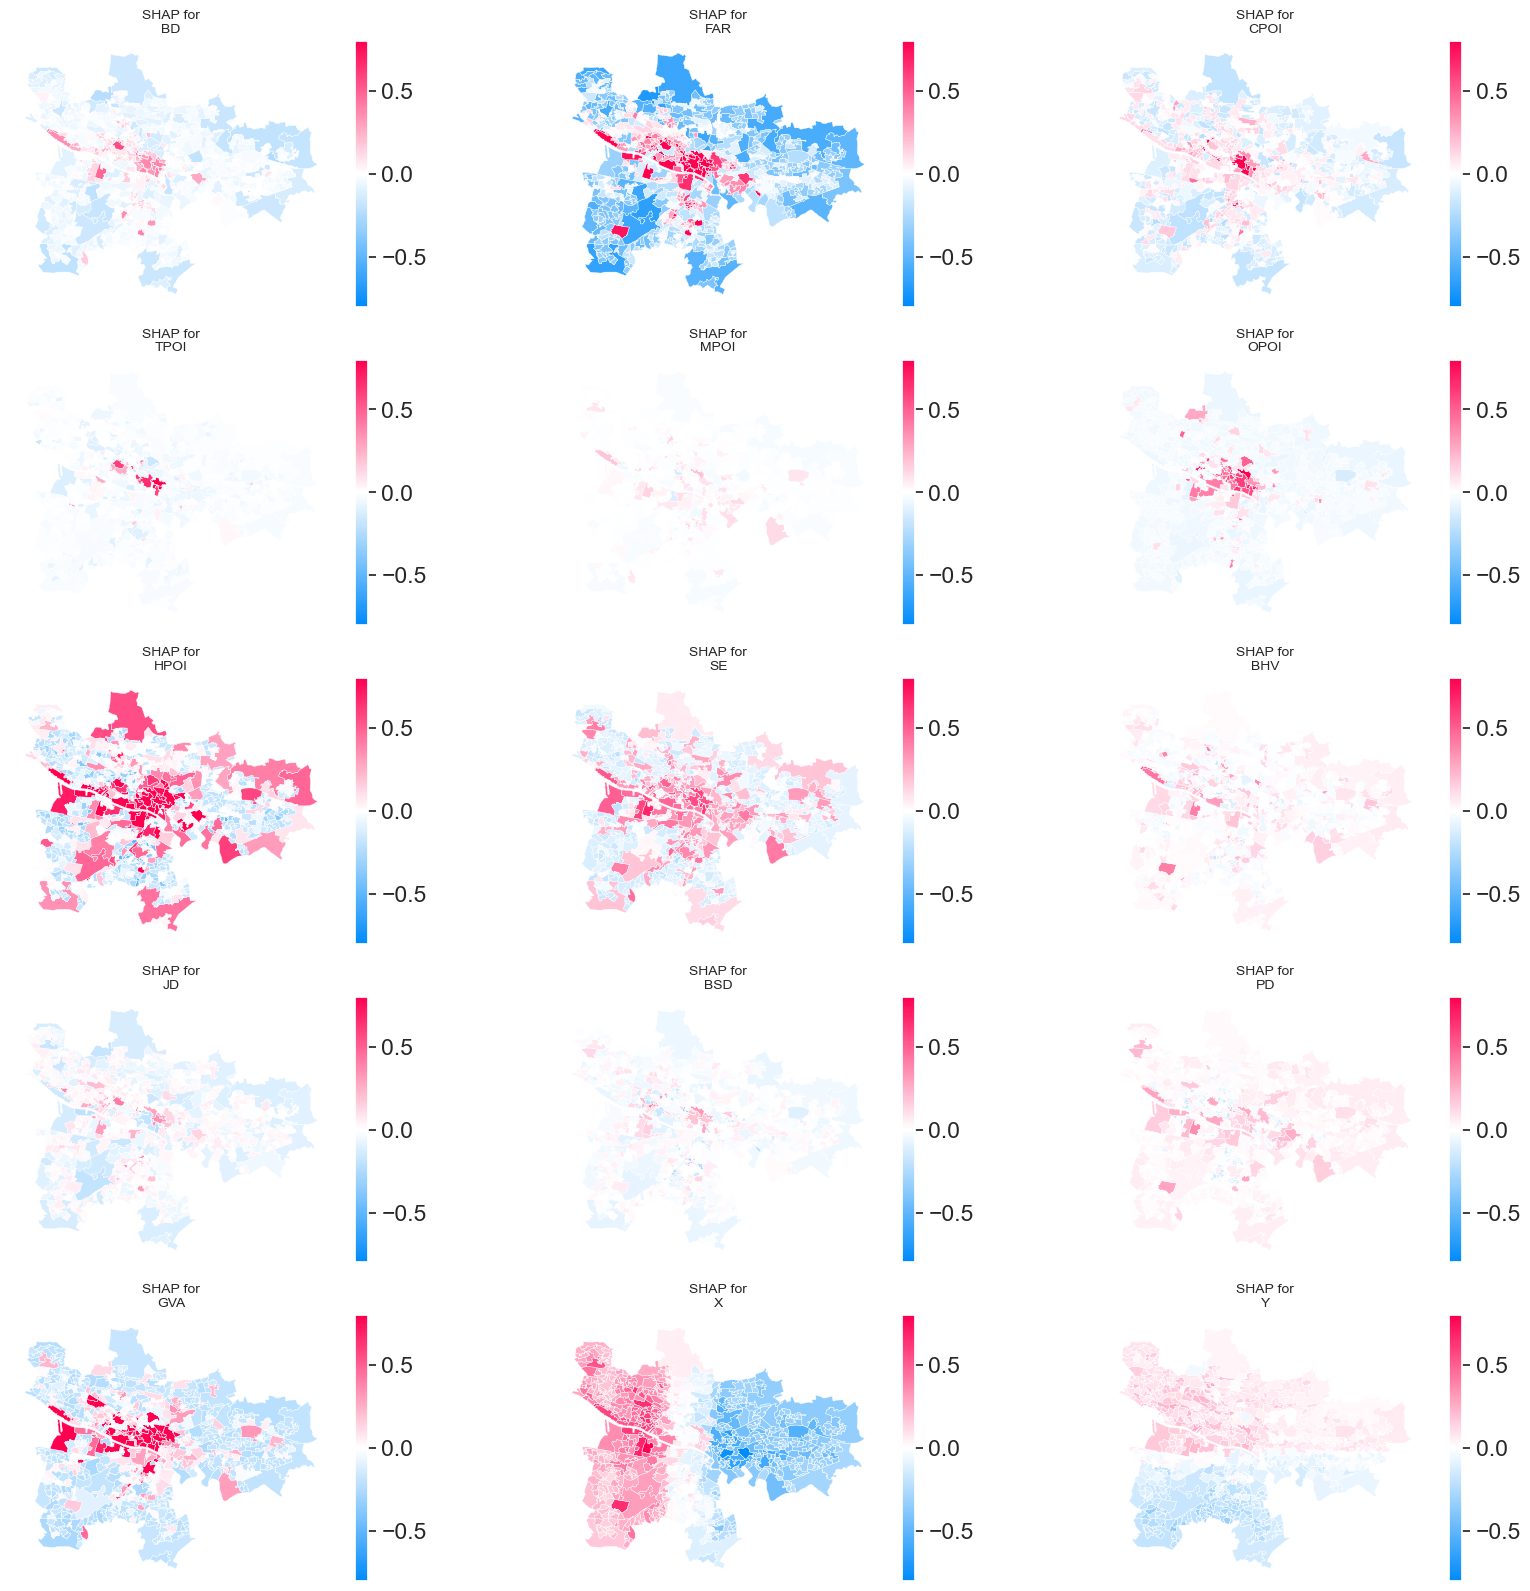

In [214]:

fig, ax = plt.subplots(5,3,figsize=(20,20))

for j in range(len(X_vars)):
    ax = ax.ravel()
    df_geo.plot(ax=ax[j],column = shap_values.values[:,j],legend=True,
             vmin=-0.8,vmax=0.8,cmap=shap.plots.colors.red_white_blue,**{'edgecolor':'white','linewidth':0.3})
    ax[j].set_title("SHAP for\n" + X_vars[j],fontsize=10)
    ax[j].set_axis_off()
    
#fig.delaxes(ax[-1])